## Medical

In [17]:
from math import *
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import stats
import cv2
import keras
from keras.models import Sequential, model_from_yaml, Model
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Convolution2D, Flatten, MaxPooling2D,Input, Concatenate
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from tensorflow.python.client import device_lib
from tensorflow.python.ops import array_ops
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from keras.applications.densenet import DenseNet169
import albumentations
import seaborn as sns

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
warnings.filterwarnings('ignore')

print(device_lib.list_local_devices())
config = tf.ConfigProto(device_count={"CPU": 1, "GPU" : 1})
session = tf.Session(config=config)
K.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16005312929388594147
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4945621811
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10592314061358110384
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:08:00.0, compute capability: 6.1"
]


In [6]:
train_transform = albumentations.Compose([
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.OneOf([albumentations.CLAHE(clip_limit=2), 
                         albumentations.IAASharpen(), 
                         albumentations.IAAEmboss(), 
        albumentations.RandomBrightness(), 
                         albumentations.RandomContrast(),
        albumentations.Blur(), 
                          albumentations.GaussNoise()
                         ], p=0.25), 
        albumentations.HueSaturationValue(p=0.25), 
        albumentations.ShiftScaleRotate(shift_limit=0.10, scale_limit=0.10, rotate_limit=0, p=0.5),
        albumentations.Normalize(p=1)
    
    ])



val_transform = albumentations.Compose([
    albumentations.Normalize(p=1)
    ])

test_transform = albumentations.Compose([
    albumentations.RandomRotate90(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.Normalize(p=1)
    ])


def preprocess_train(image):
    return (train_transform(image = image.astype(np.uint8))['image'])

def preprocess_val(image):
    return (val_transform(image = image.astype(np.uint8))['image'])
    
def preprocess_test(image):
    return (test_transform(image = image.astype(np.uint8))['image'])

def preprocess_np(image):
    return (image.astype(np.uint8))


In [7]:
indep = np.load("indep.npy")
dep = np.load("dep.npy")
indep_val = np.load("indep_val.npy")       
dep_val = np.load("dep_val.npy")


In [8]:
class NPGenerator(keras.utils.Sequence):
    def __init__(self, batch_size=32, indep=np.empty([0,96,96,3]), dep = np.empty([0]), transform = preprocess_train):
        'Initialization'
        self.batch_size = batch_size
        self.indep = indep
        self.dep = dep
        self.index = 0
        self.transform = transform
        self.tr = (lambda x: transform(image=x))
        
    def __len__(self):
        l = int(np.floor(len(self.indep) / self.batch_size))
        if ((len(self.indep) % self.batch_size) >0):
            l+=1
        return l

    def __getitem__(self, index):
        X, y = self.indep[self.index * self.batch_size:(self.index + 1) * self.batch_size], \
               self.dep[self.index * self.batch_size:(self.index + 1) * self.batch_size]
            
        X = np.array([self.tr(img.astype(np.uint8)).reshape(96,96,3) for img in X])   
        
        self.index +=1
        if (self.index>=self.indep.shape[0]/self.batch_size):
            self.index=0    
        return X, y

    def reset(self):
        self.index=0
    

In [9]:
from keras.callbacks import *

class CyclicLR(Callback):
 
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        


In [10]:
def KerasFocalLoss(target, input):
    
    gamma = 2.
    input = tf.cast(input, tf.float32)
    
    max_val = K.clip(-input, 0, 1)
    loss = input - input * target + max_val + K.log(K.exp(-max_val) + K.exp(-input - max_val))
    invprobs = tf.log_sigmoid(-input * (target * 2.0 - 1.0))
    loss = K.exp(invprobs * gamma) * loss
    
    return K.mean(K.sum(loss, axis=1))

(96, 96, 3)


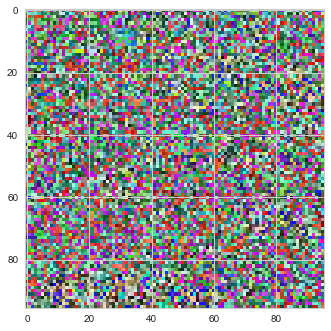

(96, 96, 3)


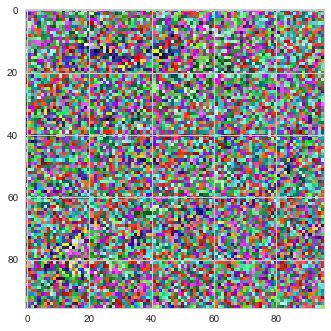

(96, 96, 3)


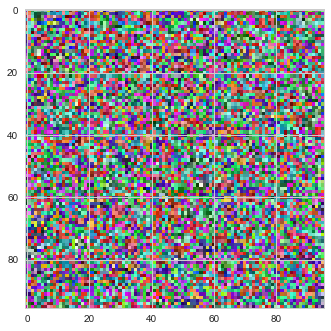

(96, 96, 3)


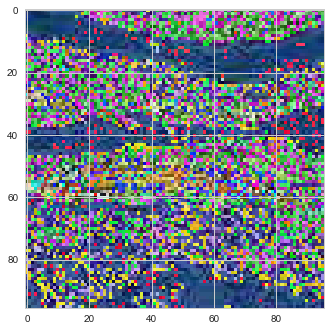

(96, 96, 3)


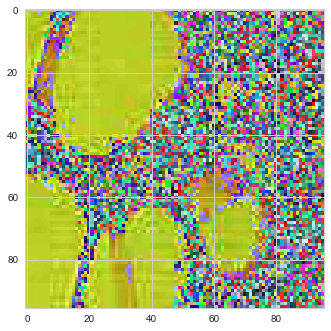

(96, 96, 3)


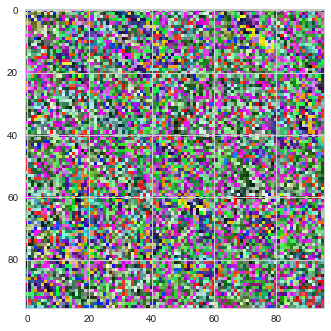

(96, 96, 3)


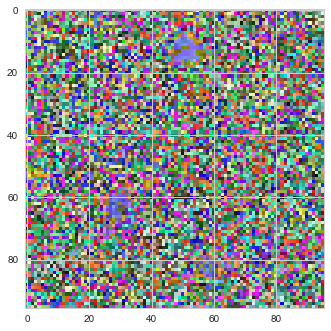

(96, 96, 3)


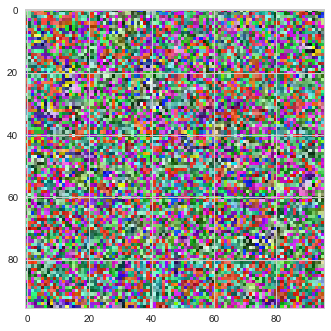

(96, 96, 3)


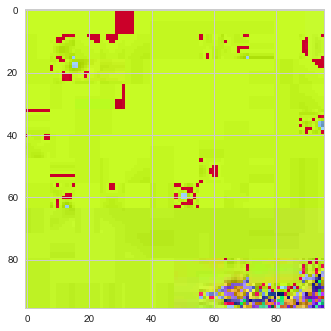

In [11]:
c = 0
for x,y in NPGenerator(indep=indep_val, dep=dep_val, batch_size=64, transform=preprocess_val):
    for i in range (1,10):
        plt.imshow(x[i])
        print (x[i].shape)
        plt.show()
    break

In [12]:
clr_triangular = CyclicLR(base_lr=5e-6, max_lr=0.005, mode="triangular2", step_size=500)

In [ ]:
with tf.device('/device:GPU:0'):
    for i in range (0, 3):
        gs1 = Sequential()
        rn = DenseNet169(include_top=False, weights='imagenet', input_tensor=Input(shape=(96, 96, 3)), input_shape=[96, 96, 3])
        rn.Trainable=False
        gs1.add(rn) 
        gs1.add(Flatten())
        gs1.add(Dense(256, activation='relu'))
        gs1.add(Dropout(0.5))
        gs1.add(BatchNormalization())
        gs1.add(Dense(64, activation='relu'))
        gs1.add(Dropout(0.5))
        gs1.add(BatchNormalization())
        gs1.add(Dense(1, activation='sigmoid'))
        gs1.compile(Adam(lr=0.001), loss="binary_crossentropy", metrics=['accuracy']) 

        with open(r"med_dn169_3_{0}.yaml".format(i), "w") as yaml_file:
            yaml_file.write(gs1.to_yaml())
        with open(r"med_dn169_3_{0}.yaml".format(i+3), "w") as yaml_file:
            yaml_file.write(gs1.to_yaml())

        gs1.fit_generator(generator=NPGenerator(indep=indep, dep=dep, batch_size=64, transform=preprocess_train), 
                          validation_data=NPGenerator(indep=indep_val, dep=dep_val, batch_size=64, transform=preprocess_val), 
                          steps_per_epoch=indep.shape[0]/64/5,
                          validation_steps=indep_val.shape[0]/64/5,
                          epochs=200, verbose=1, callbacks = [ModelCheckpoint("med_dn169_3_{0}.h5".format(i), monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max'), 
                          clr_triangular])
        gs1.save_weights("med_dn169_3_{0}.h5".format(i+3))
        

In [ ]:
"""with tf.device('/device:GPU:0'):
    for i in range (0, 3):
        gs1 = Sequential()
        rn = DenseNet169(include_top=False, weights='imagenet', input_tensor=Input(shape=(96, 96, 3)), input_shape=[96, 96, 3])
        rn.Trainable=False
        gs1.add(rn)
        out1 = GlobalMaxPooling2D()(rn)
        out2 = GlobalAveragePooling2D()(rn)
        out3 = Flatten()(rn)
        out = Concatenate(axis=-1)([out1, out2, out3])
        gs1.add(Dropout(0.5))(out)
        gs1.add(BatchNormalization())
        gs1.add(Dense(256, activation='relu'))
        gs1.add(Dropout(0.5))
        gs1.add(BatchNormalization())
        gs1.add(Dense(64, activation='relu'))
        gs1.add(Dropout(0.5))
        gs1.add(BatchNormalization())
        gs1.add(Dense(1, activation='sigmoid'))
        gs1.compile(Adam(lr=0.001), loss="binary_crossentropy", metrics=['accuracy']) 

        with open(r"med_rn_3_{0}.yaml".format(i), "w") as yaml_file:
            yaml_file.write(gs1.to_yaml())
        with open(r"med_rn_3_{0}.yaml".format(i+3), "w") as yaml_file:
            yaml_file.write(gs1.to_yaml())

        gs1.fit_generator(generator=NPGenerator(indep=indep, dep=dep, batch_size=64, transform=preprocess_train), 
                          validation_data=NPGenerator(indep=indep_val, dep=dep_val, batch_size=64, transform=preprocess_val), 
                          steps_per_epoch=indep.shape[0]/64/5,
                          validation_steps=indep_val.shape[0]/64/5,
                          epochs=200, verbose=1, callbacks = [ModelCheckpoint("med_rn_3_{0}.h5".format(i), monitor='val_acc', verbose=1, 
                          save_best_only=True, mode='max'), 
                          clr_triangular])
        gs1.save_weights("med_rn_3_{0}.h5".format(i+3))
   """;     

In [ ]:
with tf.device('/device:GPU:0'):
    for i in range (1, 3):
        with open(r"med_dn169_3_{0}.yaml".format(i), "r") as yaml_file:
            gs1 = model_from_yaml(yaml_file.read())
            gs1.load_weights("med_dn169_3_{0}.h5".format(i))
            rn = gs1.layers[0]
            rn.Trainable = False
            set_trainable = False
            for layer in rn.layers:
                if layer.name == 'res5a_branch2a':
                    set_trainable = True
                if set_trainable:
                    layer.trainable = True
                else:
                    layer.trainable = False
            gs1.compile(RMSprop(lr=0.0001), loss="binary_crossentropy", metrics=['accuracy'])

            with open(r"med_dn169_4_{0}.yaml".format(i), "w") as yaml_file:
                yaml_file.write(gs1.to_yaml())
            gs1.fit_generator(generator=NPGenerator(indep=indep, dep=dep, batch_size=64, transform=preprocess_train), 
                              validation_data=NPGenerator(indep=indep_val, dep=dep_val, batch_size=64, transform=preprocess_val), 
                              steps_per_epoch=indep.shape[0]/64/5,
                              validation_steps=indep_val.shape[0]/64/5,
                              epochs=20, verbose=1, callbacks = [ModelCheckpoint("med_dn169_4_{0}.h5".format(i), monitor='val_acc', verbose=1, 
                              save_best_only=True, mode='max'),
                              ReduceLROnPlateau(monitor='val_acc', factor=0.85, patience=2, cooldown=0, verbose=1, mode='max', min_lr=1e-6)                                 ])


Epoch 1/20
200/200 [==============================] - 98s 489ms/step - loss: 0.1601 - acc: 0.9412 - val_loss: 0.2889 - val_acc: 0.8967

Epoch 00001: val_acc improved from -inf to 0.89667, saving model to med_dn169_4_1.h5
Epoch 2/20
200/200 [==============================] - 45s 223ms/step - loss: 0.1644 - acc: 0.9412 - val_loss: 0.2735 - val_acc: 0.9050

Epoch 00002: val_acc improved from 0.89667 to 0.90500, saving model to med_dn169_4_1.h5
Epoch 3/20
200/200 [==============================] - 46s 228ms/step - loss: 0.1547 - acc: 0.9412 - val_loss: 0.2967 - val_acc: 0.8971

Epoch 00003: val_acc did not improve from 0.90500
Epoch 4/20
200/200 [==============================] - 46s 229ms/step - loss: 0.1534 - acc: 0.9465 - val_loss: 0.2487 - val_acc: 0.9123

Epoch 00004: val_acc improved from 0.90500 to 0.91229, saving model to med_dn169_4_1.h5
Epoch 5/20
200/200 [==============================] - 46s 228ms/step - loss: 0.1556 - acc: 0.9451 - val_loss: 0.2726 - val_acc: 0.9094

Epoch 000

200/200 [==============================] - 57s 287ms/step - loss: 0.0884 - acc: 0.9695 - val_loss: 0.3692 - val_acc: 0.8979

Epoch 00018: val_acc did not improve from 0.91125
Epoch 19/20
200/200 [==============================] - 57s 287ms/step - loss: 0.0980 - acc: 0.9663 - val_loss: 0.2931 - val_acc: 0.9077

Epoch 00019: val_acc did not improve from 0.91125

Epoch 00019: ReduceLROnPlateau reducing learning rate to 3.205770281056175e-05.
Epoch 20/20
 51/200 [======>.......................] - ETA: 33s - loss: 0.0978 - acc: 0.9684

In [ ]:
fig, ax = plt.subplots(2, 1, sharex='col', figsize=(20, 10))
ax[0].set_title('Model accuracy history')
ax[0].plot(gs1.history.history['acc'])
ax[0].plot(gs1.history.history['val_acc'])
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'test'], loc='right')
ax[0].grid()

ax[1].set_title('Model loss history')
ax[1].plot(gs1.history.history['loss'])
ax[1].plot(gs1.history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'test'], loc='right')
ax[1].grid()
plt.xlabel('Epoch')
plt.show()

In [ ]:
g = []
with tf.device('/device:GPU:0'):
    for i in range (0,3):
        with open(r"med_dn169_4_{0}.yaml".format(i), "r") as yaml_file:
            m = model_from_yaml(yaml_file.read())
            m.load_weights("med_dn169_4_{0}.h5".format(i))
            g.append(m)
            rn = m.layers[0]
            rn.Trainable = False
            set_trainable = False
            for layer in rn.layers:
                if layer.name == 'res5a_branch2a':
                    set_trainable = True
                if set_trainable:
                    layer.trainable = True
                else:
                    layer.trainable = False
                    

In [44]:

out = Concatenate(axis=-1)([g[0].output, g[1].output, g[2].output])
a1 = Dropout(0.5)(out)
a2 = BatchNormalization()(a1)
a3 = Dense(1, activation='sigmoid')(a2)
for a in g[0].layers:
    a.name = a.name+"_0"
for b in g[0].layers[0].layers:
    b.name = b.name+"_0"
for a in g[1].layers:
    a.name = a.name+"_1"
for b in g[1].layers[0].layers:
    b.name = b.name+"_1"
for a in g[2].layers:
    a.name = a.name+"_2"
for b in g[2].layers[0].layers:
    b.name = b.name+"_2"
    
ma = Model([g[0].input,g[1].input, g[2].input], a3)

ma.compile(Adam(lr=0.0001), loss="binary_crossentropy", metrics=['accuracy']) 

with open(r"med_dn169_a.yaml".format(i), "w") as yaml_file:
    yaml_file.write(ma.to_yaml())

ma.fit_generator(generator=NPGenerator(indep=indep, dep=dep, batch_size=64, transform=preprocess_train), 
                  validation_data=NPGenerator(indep=indep_val, dep=dep_val, batch_size=64, transform=preprocess_val), 
                  steps_per_epoch=indep.shape[0]/64/5,
                  validation_steps=indep_val.shape[0]/64/5,
                  epochs=200, verbose=1, callbacks = [ModelCheckpoint("med_dn169_a.h5".format(i), monitor='val_acc', verbose=1, 
                  save_best_only=True, mode='max'), 
                  ReduceLROnPlateau(monitor='val_acc', factor=0.85, patience=2, cooldown=0, verbose=1, mode='max', min_lr=1e-6)                               
                                                     ])

AttributeError: can't set attribute

In [ ]:
res = np.load("res.npy")
data = pd.DataFrame()
with open(r"med_dn169_a.yaml".format(i), "r") as yaml_file:
    m = model_from_yaml(yaml_file.read())
    m.load_weights(r"med_dn169_a.h5".format(i))
    for j in range(0,16):
        print (j)
        tg = NPGenerator(indep=res, batch_size=320, transform=preprocess_test)
        a = m.predict_generator(tg ,verbose=1, steps=len(tg))
        data["model_{0}".format(i * 16 + j)] = pd.Series(a.reshape(len(a)))

In [45]:
res = np.load("res.npy")
data = pd.DataFrame()
model =[]
for i in range(0, 3):
    with open(r"med_dn169_4_{0}.yaml".format(i), "r") as yaml_file:
        m = model_from_yaml(yaml_file.read())
        m.load_weights(r"med_dn169_4_{0}.h5".format(i))
        for j in range(0,16):
            print (i, j)
            tg = NPGenerator(indep=res, batch_size=320, transform=preprocess_test)
            a = m.predict_generator(tg ,verbose=1, steps=len(tg))
            data["model_{0}".format(i * 16 + j)] = pd.Series(a.reshape(len(a)))

0 0
180/180 [==============================] - 108s 601ms/step
0 1
180/180 [==============================] - 82s 455ms/step
0 2
180/180 [==============================] - 82s 454ms/step
0 3
180/180 [==============================] - 82s 453ms/step
0 4
180/180 [==============================] - 82s 454ms/step
0 5
180/180 [==============================] - 82s 455ms/step
0 6
180/180 [==============================] - 82s 456ms/step
0 7
180/180 [==============================] - 82s 456ms/step
0 8
180/180 [==============================] - 82s 456ms/step
0 9
180/180 [==============================] - 82s 453ms/step
0 10
180/180 [==============================] - 82s 453ms/step
0 11
180/180 [==============================] - 81s 452ms/step
0 12
180/180 [==============================] - 81s 451ms/step
0 13
180/180 [==============================] - 82s 454ms/step
0 14
180/180 [==============================] - 81s 452ms/step
0 15
180/180 [==============================] - 81s 452ms/step
1

In [46]:
test_generator = ImageDataGenerator().flow_from_directory(directory=r"c:/users/ajaln/test/",
                                                    target_size=(96, 96),
                                                    color_mode="rgb", batch_size=1000,
                                                    class_mode="binary", shuffle=False)
result = pd.DataFrame()
result["id"] = test_generator.filenames
result["id"] = result["id"].str[5:45]
result["label"] = data.mean(axis=1)
result.head()
samples = pd.read_csv(r"c:/users/ajaln/sample_submission.csv", usecols=["id"])
samples = pd.merge(samples, result, on="id", how="inner")
samples.head()
samples.to_csv(r"c:/work/dataset/medical/medical_dn169_unlocked_fullaug_tta.csv", index=False)

Found 57458 images belonging to 1 classes.


In [47]:
data.to_csv(r"c:/work/dataset/medical/medical_dn169_data.csv", index=False)

In [58]:
a1 = pd.read_csv(r"C:/Work/dataset/medical/medical_0.9758.csv")
a2 = pd.read_csv(r"C:/Work/dataset/medical/medical_0.9740.csv")
a3 = pd.read_csv(r"C:/Work/dataset/medical/medical_0.9718.csv")
a4 = pd.read_csv(r"C:/Work/dataset/medical/medical_dn169_unlocked_fullaug_tta.csv")

a1["label"] = (a1["label"] + a2["label"] + a3["label"]+ a4["label"])/4
a1.loc[:, ["id", "label"]].to_csv(r"c:/work/dataset/medical/0.9761.csv", index=False)